##  Car Price Project - Algorithms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Distributions supporting rvs method
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Model selection
from sklearn.base import clone
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Score predictions of fitted model.
def score_algo(model, y, prediction, validation_score, show_ratio=True):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('R^2:', round(r2_score(y, prediction), 4))
    mae = round(mean_absolute_error(y, prediction),2)
    print('MAE:', mae)
    if show_ratio == True:
        print('Ratio to Valid Score:', round(mae/validation_score,3))

In [3]:
#Helper functions
def get_error_stats(trueY, predY, describe_on=False):
    error_table = pd.DataFrame({'trueY': trueY, 'predY' : predY})
    error_table['error'] = error_table['trueY'] - error_table['predY']
    error_table['MAE'] = abs(error_table['trueY'] - error_table['predY'])
    if describe_on == True:
        display(error_table.describe().round(2))
    return error_table

def plot_error_stat(stats, kde_switch=False):    
    ''' Describe error and plot histograms.'''
    
    error_2std = round(2*stats['error'].std(),1)
    MAE_mean  = round(stats['MAE'].mean(),1)
    MAE_50th = round(np.percentile(stats['MAE'], 50),1)
    MAE_95th = round(np.percentile(stats['MAE'], 95),1)
    
    sns.set(font_scale=1.3)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))   
    sns.distplot(stats['error'], ax=ax1, kde=kde_switch)
    ax1.set_title(f'Error Histogram - 2 std dev: {error_2std}')
    ax1.axvline(x=-error_2std, color = 'yellow', ls='--', alpha=1)
    ax1.axvline(x=error_2std, color = 'yellow', ls='--', alpha=1)
           
    sns.distplot(stats['MAE'], ax=ax2, kde=kde_switch)
    ax2.set_title(f'MAE Histogram - Avg MAE: {MAE_mean} \n50th PCTL: {MAE_50th} (yellow) \n95th PCTL: {MAE_95th} (red)')    
    ax2.axvline(x=MAE_50th, color = 'yellow', ls='--', alpha=1)  
    ax2.axvline(x=MAE_95th, color = 'red', ls='--', alpha=1)
    plt.show()
    
def plot_normal_probability(predicted, true):
    from scipy import stats
    from scipy.stats import norm
    error = true - predicted
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    stats.probplot(error, dist='norm', plot=ax)
    ax.set_title('Residuals Error - Fit to Normal Distribution')
    ax.set_xlabel('Theoretical Quantiles'); ax.set_ylabel('Ordered Values');   

def plot_boxplot_w_data(colname, df, figsize=(15,3), title='Boxplot', xlimit=100_000):
    '''Returns boxplot with orange data points overlaid.'''
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set(xlim = (0,xlimit))
    ax=sns.boxplot(x=colname, data=df, linewidth=3, fliersize=6)
    ax=sns.stripplot(x=colname, data=df, color="orange", jitter=0.2, size=3)  #Credit: https://python-graph-gallery.com/39-hidden-data-under-boxplot/
    ax.set_title(f'{title}')    
    plt.show()

In [4]:
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

In [5]:
#Read in data tables.  Put quotes around table to make case-sensitive.
vehicle=pd.read_sql('SELECT * from vehicle', engine, index_col='index')
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
vehicle.index.name=None; train.index.name=None; test.index.name=None;

##  Nonlinear Models - LightGBM

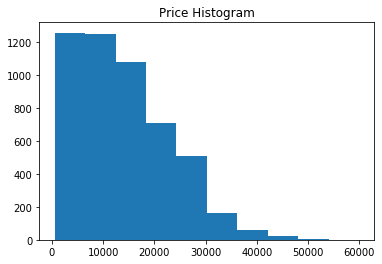

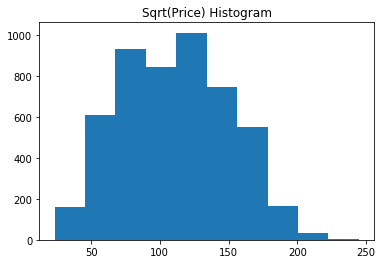

In [6]:
#***************Normalize Price.  Improves heteroskedastic residuals variances.**************
plt.hist(train['Price']); plt.title('Price Histogram'); plt.show();

train['Price'] = np.sqrt(train['Price'])
test['Price'] = np.sqrt(test['Price'])

plt.hist(train['Price']); plt.title('Sqrt(Price) Histogram'); plt.show();

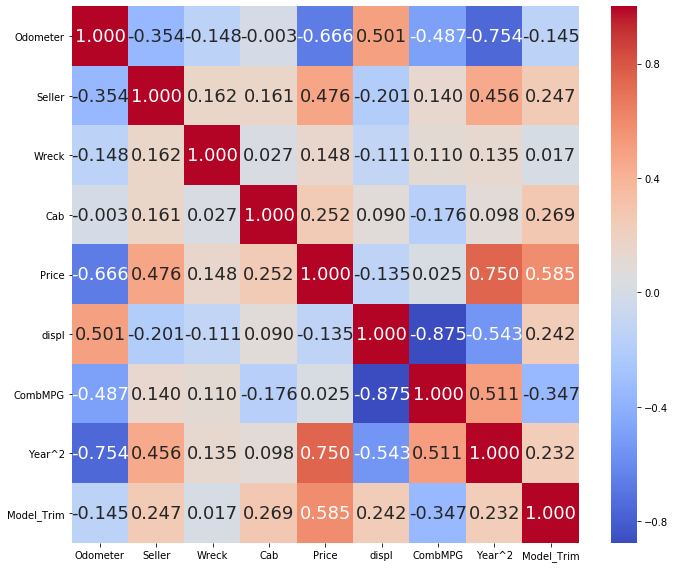

In [7]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 18}, fmt=".3f")
plt.tight_layout()

In [8]:
#Split out Price.
trainX = train.copy()
trainY = trainX.pop('Price')

testX = test.copy()
testY = testX.pop('Price')

### LightGBM model

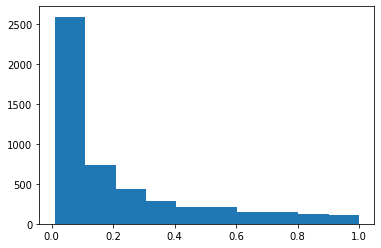

In [9]:
#Log uniform distribution from scikit-optimize
plt.hist(Real(0.01, 1.0, 'log-uniform').rvs(n_samples=5000))
plt.show()

In [10]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,200),
            "num_leaves": randint(2, 600),
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfittinga
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Instantiate random_search.
lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30, cv=5, n_jobs=-1, refit=True,\
                           scoring='neg_mean_absolute_error', return_train_score=False,random_state=40)

#Tune model with CV. Model will automatically refit on full train with best parameters.
lgb_model.fit(trainX, trainY)

#Tuned model best score.
best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}','\n')
mean_score = np.round(lgb_model.cv_results_["mean_test_score"],2)
print(f'## mean valid scores: {mean_score})', '\n')
print(f'## best valid score: {-lgb_model.best_score_:.2f} +- {best_score_std:.2f}','\n')   
print('## Best parameters:')
best_par = lgb_model.best_params_      
pprint.pprint(best_par)
      
#SCORE model on full data (thanks to refit).
y_test_pred = lgb_model.predict(testX)
print('\nSqrt(test Price):')
score_algo(lgb_model, testY, y_test_pred, -lgb_model.best_score_)
print('\ntest Price:')
score_algo(lgb_model, testY**2, y_test_pred**2, -lgb_model.best_score_, show_ratio=False) 

#Get feature importances using eli5.
perm = PermutationImportance(lgb_model, n_iter=20).fit(testX, testY)
display(eli5.show_weights(perm, feature_names = testX.columns.tolist()))

## Grid iters checked: 30 

## mean valid scores: [-10.09  -8.46  -8.15 -11.81  -8.77  -9.17 -10.73  -9.7   -8.59 -15.07
 -10.76  -8.86  -8.72 -17.74  -8.41 -10.49  -8.95  -8.79  -9.31  -8.
  -8.24  -8.78 -13.39  -8.83 -15.3   -8.57  -8.11  -8.53  -8.24  -9.01]) 

## best valid score: 8.00 +- 0.20 

## Best parameters:
{'bagging_fraction': array([0.09036643]),
 'feature_fraction': 0.7803989268691623,
 'lambda_l1': array([8.0286736e-09]),
 'lambda_l2': array([5.69078485e-07]),
 'learning_rate': array([0.11325672]),
 'max_bin': 4036,
 'max_depth': 29,
 'min_data_in_leaf': 26,
 'n_estimators': 163,
 'num_leaves': 61,
 'subsample_for_bin': 327002}

Sqrt(test Price):
-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
R^2: 0.9242
MAE: 8.12
Ratio to Valid Score: 1.015

test Price:
-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
------------------------------

Weight,Feature
16.7131 ± 1.2579,Year^2
7.8480 ± 0.8727,Odometer
7.7652 ± 0.9037,Model_Trim
5.8311 ± 0.7102,CombMPG
1.0741 ± 0.2844,displ
0.8787 ± 0.2052,Seller
0.7135 ± 0.2897,Wreck
0.4627 ± 0.1676,Cab


#### Residuals Plot Functions

In [11]:
# Residuals helper functions
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots error histogram.  Plots regression of predicted vs true.
    Returns indices of 3 sigma anomalies.
    '''
    anomaly_locs = []
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std; lower_lim = mean - three_std;
    sns.set(font_scale=1.3)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,36))
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted'); ax1.set_ylabel('Error - True less Predicted');
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(true.iloc[elem:elem+1].index[0])  #loc
        if (y_val > upper_lim or y_val < lower_lim):
            anomaly_locs.append(true.iloc[elem:elem+1].index[0])
            ax1.text(x=x_val+0.5, y=y_val+0.5, s=label_str, horizontalalignment = 'left', size=16, color='r')
                    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error'); ax2.set_ylabel('Frequency');
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted'); ax3.set_ylabel('True');
    return anomaly_locs

error count: 5057 | error avg: 0.0 | high pred percent: 50.0 | low pred percent: 50.0


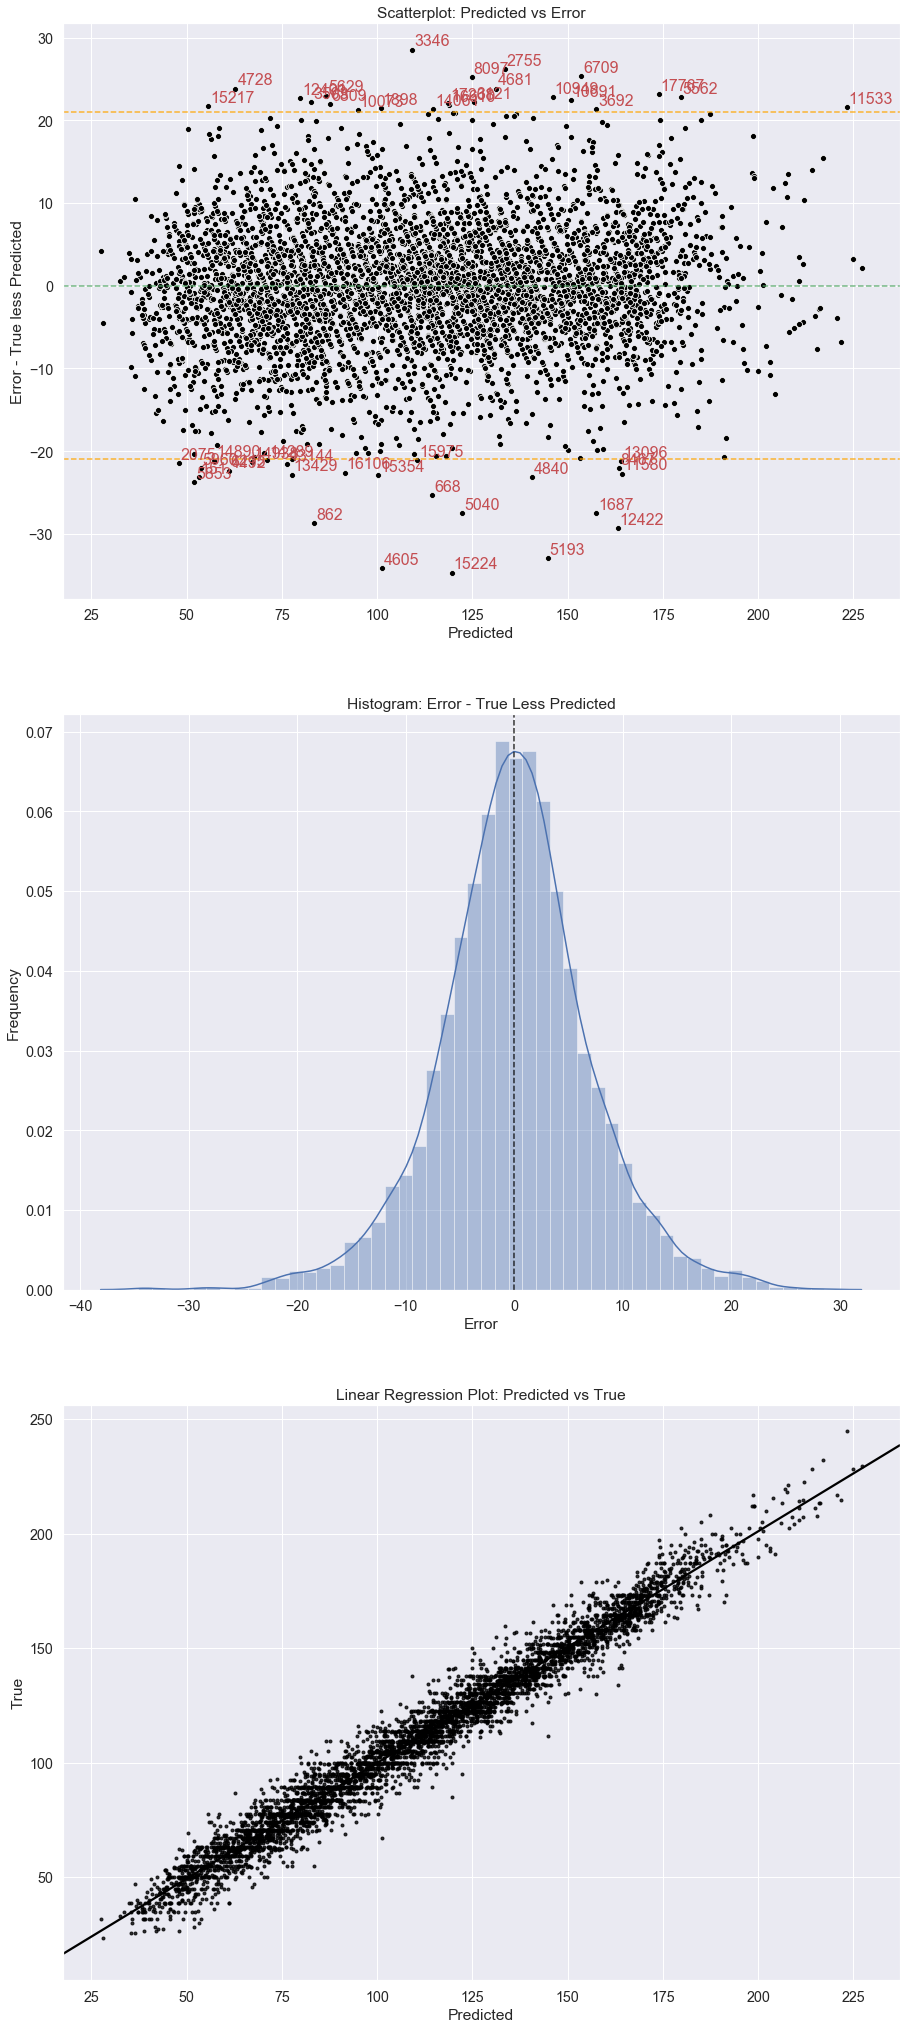

In [12]:
#LightGBM - Plot train residuals.
y_trn_pred = lgb_model.predict(trainX)
anomal = plot_residuals(predicted=y_trn_pred, true=trainY)

error count: 564 | error avg: -0.3 | high pred percent: 52.3 | low pred percent: 47.7


[14, 2116, 17760, 2176, 53, 6609, 3177, 5951]

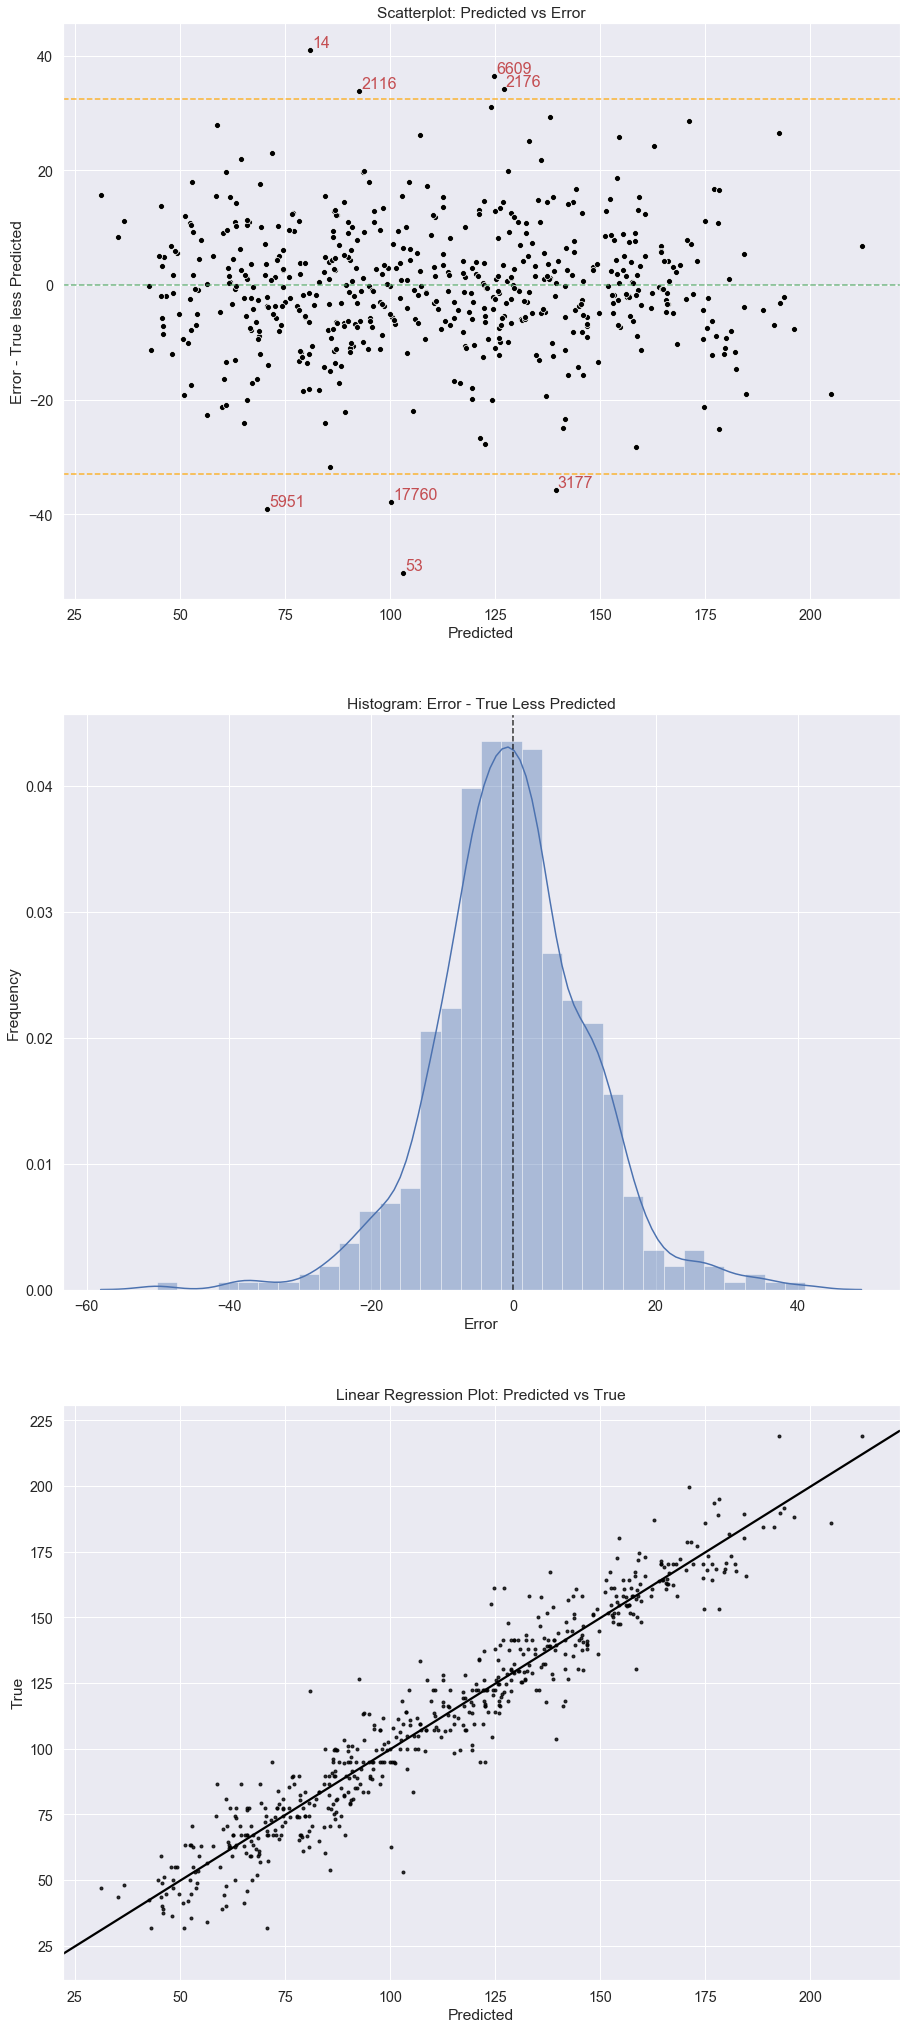

In [13]:
#LightGBM - Plot test residuals.
plot_residuals(predicted=y_test_pred, true=testY)

## Linear Regression Model

In [14]:
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
train.index.name=None; test.index.name=None;
train.shape

(5057, 9)

In [15]:
train.head(1)

,Odometer,Seller,Wreck,Cab,Price,displ,CombMPG,Year^2,Model_Trim
10889,18815.0,16651.319942,16201.653543,13170.193466,13700.0,2.0,29.5,4072324.0,8301.585366


In [16]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

# #Normalize Price
trainY = np.sqrt(trainY)
testY = np.sqrt(testY)

In [17]:
def scale_num_df(train_df, test_df, numer_cols, scaler):
    '''Scale train.  Transform test with the same scaling stats.
    Returns scaled train and scaled test.'''
    from sklearn.preprocessing import RobustScaler
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    return scaled_trn_num_df, scaled_tst_num_df

#Standard scale so regression coefficient units are the same.
trainX, testX = scale_num_df(trainX.copy(), testX.copy(), trainX.columns, StandardScaler())

In [18]:
trainX.describe().round(2)

,Odometer,Seller,Wreck,Cab,displ,CombMPG,Year^2,Model_Trim
count,5057.00,5057.00,5057.00,5057.00,5057.00,5057.00,5057.00,5057.00
mean,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.76,-1.44,-3.64,-1.10,-1.80,-1.83,-3.32,-2.11
25%,-0.81,-1.44,-0.22,-0.33,-0.94,-0.70,-0.58,-0.79
50%,-0.08,0.70,-0.22,-0.33,0.01,-0.25,0.20,0.30
75%,0.71,0.70,-0.22,-0.33,0.78,0.40,0.79,0.95
max,4.82,0.70,4.17,2.82,1.83,3.06,1.58,2.76


## `Tune Linear Models with Cross Validation`

In [19]:
def train_and_valid(what_model, num_folds, X, y):
    fold_mae=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns
        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_mae.append(round(mean_absolute_error(valid_y, valid_pred), 2))
        
    print(f'***Tune {type(what_model).__name__}***\n## Fold MAE:', fold_mae)
    avg_mae = round(np.mean(fold_mae),1)
    print('## Avg MAE:', avg_mae,'+-', round(np.std(fold_mae),1))
    print('## Clone R^2:', round(clone_model.score(X,y),3))
    return clone_model, avg_mae

In [20]:
#Linear regression finds the coeficcients that minimize the residual sum of squares.
lr=LinearRegression(fit_intercept=True)
lr_clone, avg_mae=train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)

***Tune LinearRegression***
## Fold MAE: [11.63, 12.09, 12.06, 11.93, 11.71, 11.76, 12.19, 11.85, 12.34, 10.99]
## Avg MAE: 11.9 +- 0.4
## Clone R^2: 0.845


In [21]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(lr_clone,n_iter=20).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
0.6578 ± 0.0298,Year^2
0.2948 ± 0.0120,CombMPG
0.2249 ± 0.0092,Odometer
0.1236 ± 0.0044,Model_Trim
0.0083 ± 0.0017,Seller
0.0053 ± 0.0006,Cab
0.0034 ± 0.0010,Wreck
0.0027 ± 0.0007,displ


## `Linear Model Predictions - Fit on 100% of train`

In [22]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution, only for coefficient
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
print('Sqrt(Price):')
score_algo(linregr, testY, y_pred_linregr, avg_mae)

#Score original Price
print('\nPrice:')
score_algo(linregr, testY**2, y_pred_linregr**2, avg_mae, show_ratio=False)

Sqrt(Price):
-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.8561
MAE: 11.52
Ratio to Valid Score: 0.968

Price:
-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.8378
MAE: 2603.86


In [23]:
#Linear Regression Coefficients. Each feature has the same scale: unit of standard deviation above/below the mean.
pd.DataFrame({'feature': trainX.columns, 'coef' : np.round(linregr.coef_,2)})

,feature,coef
0,Odometer,-13.00
1,Seller,2.52
2,Wreck,1.68
3,Cab,2.01
4,displ,-1.49
5,CombMPG,-14.95
6,Year^2,22.46
7,Model_Trim,9.70


error count: 564 | error avg: -0.1 | high pred percent: 55.0 | low pred percent: 45.0


[14, 11892, 17760, 788, 7189, 4239, 7420]

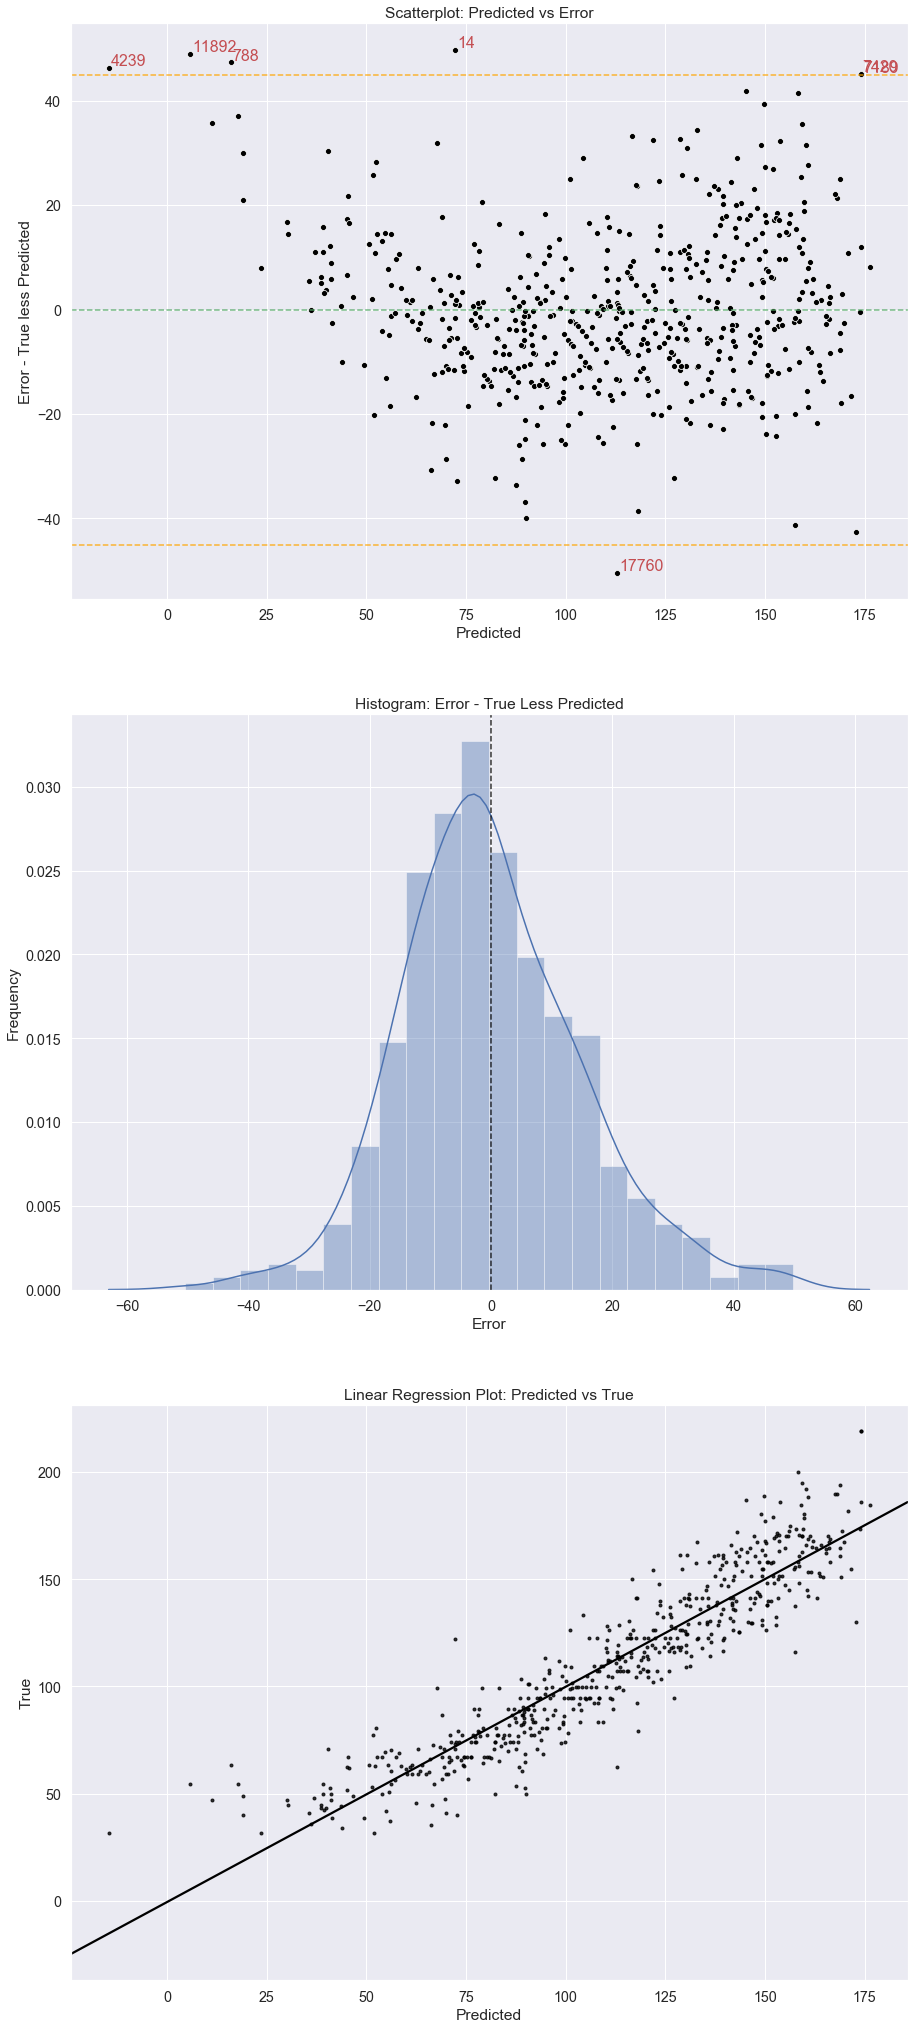

In [24]:
#Get test residuals.  A non-normal error means errors are not random.  Are there outliers?  Try transforming features
#to make them closer to normally distributed.  We will not go down this path today as we have a more accurate LightGBM
#model with better-looking residuals.  LightGBM can model non-linear relationships, in contrast to a linear regression.
plot_residuals(predicted=y_pred_linregr, true=testY)

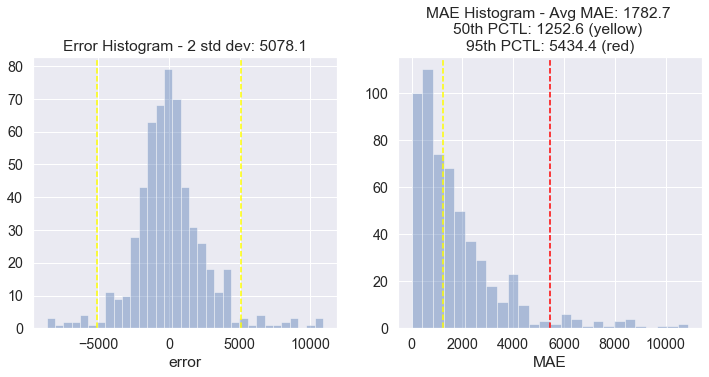

In [25]:
#LightGBM detailed test error stats in DOLLARS
lgb_error = get_error_stats(trueY=testY**2, predY=y_test_pred**2)
plot_error_stat(lgb_error)

In [35]:
#Research biggest magnitude errors
pd.set_option('max_colwidth', 80)
research = lgb_error.merge(vehicle.copy(), how='inner', left_index=True, right_index=True)
research.sort_values(by='MAE', ascending=False).head(20)

,trueY,predY,error,MAE,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Wreck,Cab,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG,DownFlag,Year^2,Model_Trim
7189,47999.0,37095.793545,10903.206455,10903.206455,https://houston.craigslist.org/ctd/d/saint-cloud-2018-ford-150-f-xlt/7016034...,2018 Ford F-150 F150 F 150 XLT - MIDWESTS #1 PRE-OWNED TRUCK DEALER!!,houston,2018,None,4115.0,2018 FORD F-150,ford,f-150,xlt,dealer,None,None,47999.0,(+ Minnesota Truck Headquarters),"\n ,\n,\n\n,\n\n,\n\n,\n\n\n,\n\n,\n\n,\n\n,\n\n,\n\n,\n\n,\n\n,\n\n,...","{'0': '<span><b>2018 FORD F-150</b></span>', '1': '<span>VIN: <b>1FTEW1EP4JK...","{'0': 'https://images.craigslist.org/00R0R_dElUsfRF1TI_600x450.jpg', '1': 'h...",7016034219,1FTEW1EP4JKF04492,3.40,19.0,None,4072324,f-150_xlt
7193,39892.0,29303.564318,10588.435682,10588.435682,https://houston.craigslist.org/ctd/d/saint-cloud-2016-ford-150-f-xlt/7016042...,2016 Ford F-150 F150 F 150 XLT - MIDWESTS #1 PRE-OWNED TRUCK DEALER!!,houston,2016,None,41048.0,2016 FORD F-150,ford,f-150,xlt,dealer,None,None,39892.0,(+ Minnesota Truck Headquarters),"\n ,\n,\n\n,\n\n,\n\n,\n\n\n,\n\n,\n\n,\n\n,\n\n,\n\n,\n\n,\n\n,\n\n,...","{'0': '<span><b>2016 FORD F-150</b></span>', '1': '<span>VIN: <b>1FTEW1EG6GF...","{'0': 'https://images.craigslist.org/00a0a_hxtKlw8tIOL_600x450.jpg', '1': 'h...",7016042236,1FTEW1EG6GFB32722,3.50,18.5,None,4064256,f-150_xlt
6609,25980.0,15554.652701,10425.347299,10425.347299,https://houston.craigslist.org/ctd/d/humble-2008-ford-150-lariat-supercrew/7...,2008 Ford F-150 LARIAT SUPERCREW 2WD FOOSE,houston,2008,None,45502.0,2008 Ford F-150,ford,f-150,lariat,dealer,None,supercrew,25980.0,(Houston Humble Kingwood Texas),"\n ,\n2008 Ford F-150 LARIAT SUPERCREW 2WD FOOSE - $25,980,\n\n2008 -...","{'0': '<span><b>2008 Ford F-150</b></span>', '1': '<span>VIN: <b>1FTPW12578K...","{'0': 'https://images.craigslist.org/00L0L_eiF0x6eR4kI_600x450.jpg', '1': 'h...",7011754944,1FTPW12578KE27512,5.40,15.0,None,4032064,f-150_lariat
2176,26000.0,16133.779543,9866.220457,9866.220457,https://dallas.craigslist.org/dal/cto/d/dallas-2014-ford-150-stx-4x4/7018364...,2014 Ford F-150 STX 4X4,dallas,2014,None,70000.0,2014 ford f-150,ford,f-150,stx,owner,None,None,26000.0,None,"\n ,\n26k OBO! Brand new tires! Great condition! No mechanical issues...","{'0': '<span><b>2014 ford f-150</b></span>', '1': '<span>cylinders: <b>8 cyl...",{},7018364188,None887,3.70,17.0,None,4056196,f-150_stx
18178,27991.0,19065.576298,8925.423702,8925.423702,https://houston.craigslist.org/ctd/d/carrollton-2014-ford-mustang-gt-roush/7...,2014 *Ford* *Mustang* *GT* Roush Stage-2 Supercharged Show Car,houston,2014,None,61235.0,2014 Ford Mustang,ford,mustang,gt,dealer,None,None,27991.0,(Ford Mustang),"\n ,\n\n ,\n,\n,\n,\n,\n,\n,\n,\n,\n2014\n,\n,\nFord_\n,\n,\nMus...","{'0': '<span><b>2014 Ford Mustang</b></span>', '1': '<span>VIN: <b>1ZVBP8CF9...","{'0': 'https://images.craigslist.org/00s0s_bI2CcGXIxBS_600x450.jpg', '1': 'h...",7042651753,1ZVBP8CF9E5240562,4.35,21.0,None,4056196,mustang_gt
3177,10750.0,19419.665414,-8669.665414,8669.665414,https://dallas.craigslist.org/dal/cto/d/dallas-2013-mustang-gt/7016659229.html,2013 Mustang Gt,dallas,2013,None,57400.0,2013 ford mustang gt,ford,mustang,gt,owner,None,None,10750.0,(Dallas),"\n ,\n57k miles everything works drives amazing sounds amazing bring ...","{'0': '<span><b>2013 ford mustang gt</b></span>', '1': '<span>condition: <b>...","{'0': 'https://images.craigslist.org/01515_aAvhQ96QLCo_600x450.jpg', '1': 'h...",7016659229,None1290,4.35,21.0,None,4052169,mustang_gt
17408,23995.0,15348.471473,8646.528527,8646.528527,https://houston.craigslist.org/ctd/d/houston-2016-ford-transit-cargo-van/703...,2016 Ford Transit Cargo Van Cargo Van with Liftgate,houston,2016,None,112000.0,2016 Ford Transit Cargo Van,ford,transit,cargo,dealer,None,None,23995.0,"(Houston, TX)","\n ,\n,\n,\naddress: ,phone: ☎ , ,\nlink: , ,\ncontact:...","{'0

In [27]:
# #View averages by Model_Trim_Year
# research.groupby(['Model_Trim']).agg({'MAE':'mean', 'trueY':'mean'}).sort_values(by='MAE', ascending=False)

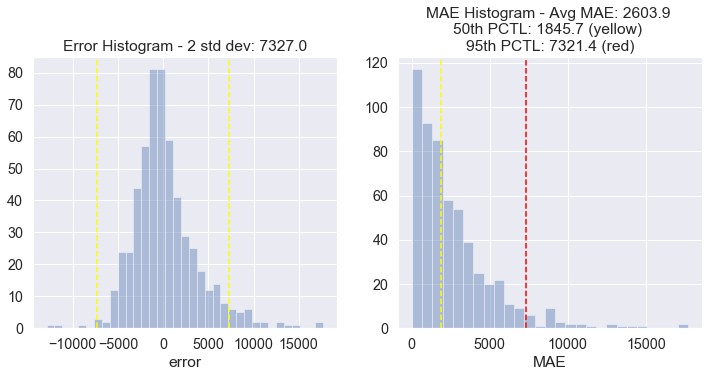

In [28]:
#Linear Regression detailed test error stats in DOLLARS
lr_error = get_error_stats(trueY=testY**2, predY=y_pred_linregr**2)
plot_error_stat(lr_error)

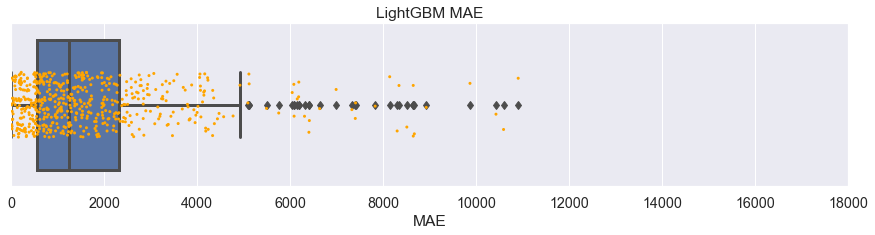

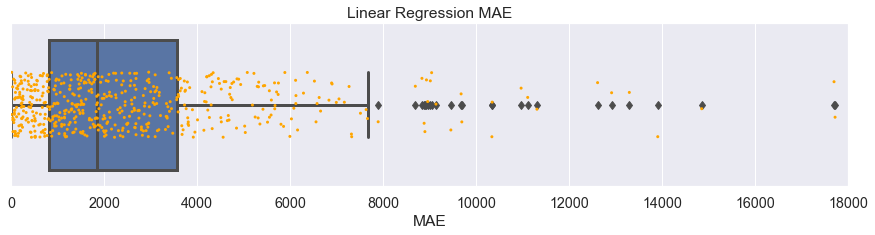

In [37]:
#Dollar MAE Boxplots - LGB vs Linear Regression
plot_boxplot_w_data(colname='MAE', df=lgb_error, title='LightGBM MAE', xlimit=18_000) 
plot_boxplot_w_data(colname='MAE', df=lr_error, title='Linear Regression MAE', xlimit=18_000)